# REAL ESTATE PRICE PREDICTION 

#*Background: Use Case*

Your task here is to use the supplied dataset describing homes, including four photos per home and some other structured features, along with an associated home sale price label, to try to fit a predictive model of sale price.

The use case here is as follows. Your customers are individual sellers, buyers, and real estate agent, who wishes to set their sale price, or their offer price on a new home. You can assume the user will always have these features available to them at the time of prediction (i.e., the four photo types in question, as well as the structured features). 

## Image pre-processing

* **Small image size**: Smaller image resizing allow mini-batches learning and also support the compute limitations since the model trains faster. However, too small image makes it difficult for the CNN to learn the features required for classification or detection which miseads predictions depending on the model and prediction problem.

* **Large image size**: Models train slower on large images because an input image that is twice as large requires our network to learn from four times as many pixels. It might be the case that large image improve prediction performance and zero-padding had no effect on the classification accuracy depending on the model.

* Therefore, It is important to balance between small and large image sizes and **choose optimal image resizing** point. Moreover, in the case of variable-sized images, many machine learning models require fixed and same dimensions images. Here, given our computational limit and prediction problem, hwe decided to resize image to **(128, 128)** to ensure best prediction performance and mini batches learning.

## Feature engineering

* **Image predictors**: we kept all image features - front, bathroom, bedroon, and kitchen because each type of images represents distict component of house. There wasn't any missing values and we resized it.

* **bedrooms, bathroom, area**: These are numerical variables. We kept these because it has information about house size. The scale is different and standard deviation of 'area' is high, so we conducted normalization to the layer when we build the model.

* **Zipcode**: We decided to keep it because it indicates significant information like location. However, zipcode is imbalanced, so we preprocessed it.
 * Only 49 unique values in 'zipcode' feature, 21 zipcodes has 1 row in it
 * Therefore, we maintained only the first three digits for zipcode to compress and got 7 zipcodes which have 1 row in it.  The first number represents a certain group of U.S. states and the second and third numbers represent a region in that group of states. 
 * After that, we did **one hot encoding** to process categorical variable. Here's no hold sample to break our model, and there is also a fixed number of zip codes in the US.


* Price: This is target variable.

#**Importing the Data**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image
import cv2
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:

# Replace with your basepath to the extracted dataset in your Google Drive
basePath = '/content/drive/MyDrive/BA865/datasets/HousesDataset'

# basePath = 'gdrive/MyDrive/BA865/Week 5/datasets/Houses Dataset'

In [ ]:

# These are the column headers for the home characteristics data.
cols = ['bedrooms','bathrooms','area','zipcode','price']

# We first pull in the numeric features for houses from the text file.
numericData = pd.read_csv(f'{basePath}/all/HousesInfo.txt', sep=" ", header=None, names=cols)


# Labels and Predictors
* **Labels**: Price (numeric)
* **Images**: 4 types of images, 535 rows, resized it to 128,128 to balance between computational limitation and performance of vision model
* **Dataframe(df)**: Numeric predictors; We dropped 'price' so that it has 4 features - bedrooms, bathrooms, area, zipcode

The shape of our kitchen image array is (535, 128, 128, 3)


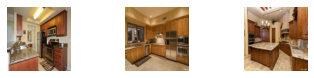

In [ ]:
# Pulling out the labels
labels = numericData['price']

# Image size = 128,128
image_size = (128,128)

# Reading the images into memory may take a minute - be patient :).
def read_images(imageType):
  image_list = []
  for file in glob.glob(f"{basePath}/all/{imageType}/*"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
  return np.stack(image_list)

front_image = read_images("frontal")
bathroom_image = read_images("bathroom")
bedroom_image = read_images("bedroom")
kitchen_image = read_images("kitchen")

print(f'The shape of our kitchen image array is {kitchen_image.shape}')

# Our 535 houses' images are all now in memory as 200x200 pictures, with 3 channels (RGB). Feel free to change the image size.
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(kitchen_image[i])
    plt.axis("off")

In [ ]:
# Shuffle the different arrays, in unison (preserving row ordering across the arrays)
shuffled_indices= np.arange(front_image.shape[0])
np.random.shuffle(shuffled_indices)

front_image = front_image[shuffled_indices]
kitchen_image = kitchen_image[shuffled_indices]
bathroom_image = bathroom_image[shuffled_indices]
bedroom_iamge = bedroom_image[shuffled_indices]
numericData = numericData.iloc[shuffled_indices]
labels = labels[shuffled_indices]

In [ ]:
#Image feature shape
front_image.shape

(535, 128, 128, 3)

In [ ]:
#Creating data frame without 'price'
df = numericData.iloc[:,:4]

In [ ]:
#It has 4 features
df.shape

(535, 4)

# Data Preprocessing

* **Bedrooms, Bathrooms, Area**: Numerical Variable. We can see the scale is different and standard deviation of 'area' is high. Therefore, We will apply **normalization method**(Batch normalization) to the numerical input layer when we build the mode.

* **Zipcode**: Zipcode is categorical variable and it is imbalanced. We will encode the zipcode but have only first three digits.

In [ ]:
df.describe()

,bedrooms,bathrooms,area,zipcode
count,535.000000,535.000000,535.000000,535.000000
mean,3.377570,2.664953,2364.904673,90937.770093
std,1.160952,0.995077,1224.556982,7141.843144
min,1.000000,1.000000,701.000000,36373.000000
25%,3.000000,2.000000,1440.000000,92276.000000
50%,3.000000,2.500000,2078.000000,92880.000000
75%,4.000000,3.000000,3067.500000,93510.000000
max,10.000000,7.000000,9583.000000,98021.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 256 to 405
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   535 non-null    int64  
 1   bathrooms  535 non-null    float64
 2   area       535 non-null    int64  
 3   zipcode    535 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 20.9 KB


## Zipcode
* We have 49 unique values in 'zipcode' feature
* Zipcode is not balanced;
  * 10 zipcodes represents 408 rows - accounting for more than 70% of total data.
  * *21 zipcodes* has only 1 row in it
* We maintained only the first three digits for zipcode because the first number representing a certain group of U.S. states and the second and third numbers represent a region in that group of states.
 * As a result, only *7 zipcodes* have 1 row in it
* After that, we did one hot encoding to process categorical variable.
* Finally, we have 31 features for numerical data frame

In [ ]:
df["zipcode"].nunique()

49

In [ ]:
df.groupby('zipcode').size().sort_values(ascending=False)


zipcode
92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
94531     22
96019     12
85255     12
81524     11
85266     11
92021     11
93111     11
95220     10
85262      9
92802      9
62234      7
98021      4
62214      4
91752      3
60002      3
85377      3
81418      2
92253      2
62025      2
92692      2
60016      2
93924      1
93720      1
94565      1
94568      1
95008      1
93314      1
36373      1
93105      1
92543      1
92040      1
90803      1
90265      1
90211      1
90038      1
85331      1
81521      1
62249      1
62088      1
62034      1
60046      1
91915      1
dtype: int64

In [ ]:
df['zipcode']=df["zipcode"]//100

In [ ]:
df.groupby('zipcode').size().sort_values(ascending=False)

zipcode
922    102
945     65
935     60
928     58
934     54
919     33
852     32
926     28
960     12
622     12
815     12
931     12
920     12
952     10
600      6
980      4
853      4
620      4
917      3
902      2
814      2
925      1
908      1
933      1
900      1
937      1
939      1
950      1
363      1
dtype: int64

In [ ]:
df = pd.get_dummies(df, columns=['zipcode'], drop_first=True)

In [ ]:
df.shape

(535, 31)

# **Build model**

* Data augmentation: we performed data augmentation to avoid overfitting.

* Normalization: We used BatchNormalization to standardize our data

* Pooling: We conducted pooling to compress data and reduce complexity, so that we can reduce overfitting.

* Padding&Stride: At the same time, we also adjusted padding to prevent the transformation from down-sampling and did strides.

* Flatten: Under each branch, we used flatten to convert the data into a 1-dimensional array for inputting it to the next layer

* We used 'relu' activation function for hidden layers and 'linear' activation for final output function because this is regression problem.

# Create a Multi-Modal NN

#*Define Your Model*

In [ ]:
def build_model(a=128, b=128, c=3, d=31): 
    data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
    ])
    
    input_image1 = layers.Input(shape=(a,b,c), name="Images1")
    x1 = data_augmentation(input_image1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")(x1)
    x1 = layers.MaxPool2D(2,strides=2)(x1)
    x1 = layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu")(x1)
    x1 = layers.MaxPool2D(2,strides=2)(x1)
    image_output1 = layers.Flatten()(x1)

    input_image2 = layers.Input(shape=(a,b,c), name="Images2")
    x2 = data_augmentation(input_image2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")(x2)
    x2 = layers.MaxPool2D(2,strides=2)(x2)
    x2 = layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu")(x2)
    x2 = layers.MaxPool2D(2,strides=2)(x2)
    image_output2 = layers.Flatten()(x2)

    input_image3 = layers.Input(shape=(a,b,c), name="Images3")
    x3 = data_augmentation(input_image3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")(x3)
    x3 = layers.MaxPool2D(2,strides=2)(x3)
    x3 = layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu")(x3)
    x3 = layers.MaxPool2D(2,strides=2)(x3)
    image_output3 = layers.Flatten()(x3)


    input_image4 = layers.Input(shape=(a,b,c), name="Images4")
    x4 = data_augmentation(input_image4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")(x4)
    x4 = layers.MaxPool2D(2,strides=2)(x4)
    x4 = layers.Conv2D(filters=64,kernel_size=3,padding="same",activation="relu")(x4)
    x4 = layers.MaxPool2D(2,strides=2)(x4)
    image_output4 = layers.Flatten()(x4)


    input_numeric = layers.Input(shape=d,name="Numbers")
    x5 = layers.BatchNormalization()(input_numeric)
    x5 = layers.Dense(3,activation="relu")(x5)
    x5 = layers.Dense(3,activation="relu")(x5)
    numeric_output = layers.Dense(5,activation="relu")(x5)


    merge = layers.Concatenate()([image_output1, image_output2, image_output3, image_output4, numeric_output])
    x6 = layers.Dense(5,activation="relu")(merge)
    x6 = layers.Dense(5, activation="relu")(x6)
    final_output = layers.Dense(1, activation="linear")(x6)

    model = keras.Model(inputs=[input_image1, input_image2, input_image3, input_image4,input_numeric],outputs=final_output)

    model.compile(optimizer="adam",loss="mae", metrics=["mae"])

    return model

#*Fit Your Model*

# Cross Validation
* We performed cross validation to ensure the compatibility and evaluate the model

In [ ]:
k = 5
num_val_samples = len(df) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 10
batch_size = 25
all_train_mae_histories = []
all_val_mae_histories = []  


print("In total, we have",len(df),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)

    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    
    val_data1 = front_image[i * num_val_samples: (i + 1) * num_val_samples] 
    val_data2 = kitchen_image[i * num_val_samples: (i + 1) * num_val_samples]
    val_data3 = bathroom_image[i * num_val_samples: (i + 1) * num_val_samples]
    val_data4 = bedroom_iamge[i * num_val_samples: (i + 1) * num_val_samples]
    val_data5 = df[i * num_val_samples: (i + 1) * num_val_samples]

    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    
    partial_train_data1 = np.concatenate(
        [front_image[:i * num_val_samples],
         front_image[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_data2 = np.concatenate(
        [kitchen_image[:i * num_val_samples],
         kitchen_image[(i + 1) * num_val_samples:]],
        axis=0)    

    partial_train_data3 = np.concatenate(
        [bathroom_image[:i * num_val_samples],
         bathroom_image[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_data4 = np.concatenate(
        [bedroom_iamge[:i * num_val_samples],
         bedroom_iamge[(i + 1) * num_val_samples:]],
        axis=0)
            
    partial_train_data5 = np.concatenate(
        [df[:i * num_val_samples],
         df[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()


    history = model.fit(x=[partial_train_data1, partial_train_data2,partial_train_data3,partial_train_data4,partial_train_data5], y=partial_train_targets,
                        validation_data=([val_data1,val_data2,val_data3,val_data4,val_data5], val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
  
    train_mae_history = history.history['mae']
    val_mae_history = history.history['val_mae']   

    all_train_mae_histories.append(train_mae_history)
    all_val_mae_histories.append(val_mae_history)


average_train_mae_history = [np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

In total, we have 535 training observations.
With a k of 5 we have 107 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Epoch 1/10
18/18 [==============================] - 7s 173ms/step - loss: 596562.9375 - mae: 596562.9375 - val_loss: 554912.3750 - val_mae: 554912.3750
Epoch 2/10
18/18 [==============================] - 2s 123ms/step - loss: 578812.8750 - mae: 578813.0000 - val_loss: 528266.9375 - val_mae: 528266.9375
Epoch 3/10
18/18 [==============================] - 2s 124ms/step - loss: 478376.0625 - mae: 478376.0625 - val_loss: 422245.2812 - val_mae: 422245.2812
Epoch 4/10
18/18 [==============================] - 2s 123ms/step - loss: 333764.1250 - mae: 333764.1250 - val_loss: 344409.8438 - val_mae: 344409.8438
Epoch 5/10
18/18 [==============================] - 2s 122ms/step - loss: 324136.0312 - mae: 324136.0312 - val_los

Plot your model's loss over epochs to undertand fitting / overfitting.

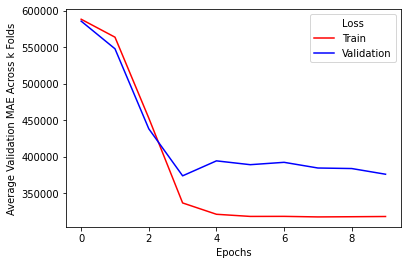

In [ ]:
import matplotlib.pyplot as plt

plt.plot(average_train_mae_history, c="r")
plt.plot(average_val_mae_history,c="b")
plt.legend(['Train','Validation'],title="Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Validation MAE Across k Folds")
plt.show()

# Final Model Configuration

We decided 10 epochs and 25 batch size for our final model.

In [ ]:
model = build_model()
model.fit(x=[front_image, kitchen_image, bathroom_image, bedroom_iamge, df],y=labels,epochs=10, batch_size=25)

Epoch 1/8
22/22 [==============================] - 7s 114ms/step - loss: 588687.1875 - mae: 588687.1875
Epoch 2/8
22/22 [==============================] - 2s 98ms/step - loss: 573008.5625 - mae: 573008.5625
Epoch 3/8
22/22 [==============================] - 2s 98ms/step - loss: 477292.5312 - mae: 477292.5312
Epoch 4/8
22/22 [==============================] - 2s 99ms/step - loss: 341145.5312 - mae: 341145.5312
Epoch 5/8
22/22 [==============================] - 2s 99ms/step - loss: 320754.7812 - mae: 320754.7812
Epoch 6/8
22/22 [==============================] - 2s 98ms/step - loss: 319242.1562 - mae: 319242.1562
Epoch 7/8
22/22 [==============================] - 2s 99ms/step - loss: 318986.0938 - mae: 318986.0938
Epoch 8/8
22/22 [==============================] - 2s 99ms/step - loss: 319313.9062 - mae: 319313.9062


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Images1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Images2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Images3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                          

# Use a Pre-Trained Model

#*Load Pre-Trained Model's CNN layers*

We will use vgg16 for the pretrained moodel

In [ ]:

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, # Throw away the densely connected layer at the end.
    input_shape=(128, 128, 3)) 

conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

#*Pre-process Your Images Through the Pre-trained Model's CNN Layers*

In [ ]:
def get_features(dataset):
  features =[]
  for image in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(image)
    features.append(preprocessed_images)
  
  all_features = np.stack(features)
  final_features = conv_base.predict(all_features)

  return final_features

In [ ]:
## YOUR CODE HERE TO PROCESS IMAGES THROUGH THE PRE-TRAINED MODEL AND STORE THEIR FEATURE VECTORS
front_features = get_features(front_image)
kitchen_features = get_features(kitchen_image)
bathroom_features = get_features(bathroom_image)
bedroom_features = get_features(bedroom_image)


In [ ]:
front_features.shape

(535, 4, 4, 512)

#*Define Your Dense Network (That Accepts the Image's Feature Vectors)*

* Data augmentation
* Flatten
* Dropout
* Batch normalization
* We used 'relu' activation function for hidden layers and 'linear' activation for final output function because this is regression problem.

In [ ]:
def model_preTrain(a=4,b=4,c=512,d=31):
    data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2),
    ])
    
    inputs1 = layers.Input(shape=(a,b,c), name="preTrain_image1")
    x1 = data_augmentation(inputs1)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(256)(x1)
    x1 = layers.Dropout(0.5)(x1)
    outputs1 = layers.Dense(1, activation="relu")(x1)

    inputs2 = layers.Input(shape=(a,b,c), name="preTrain_image2")
    x2 = data_augmentation(inputs2)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(256)(x2)
    x2 = layers.Dropout(0.5)(x2)
    outputs2 = layers.Dense(1, activation="relu")(x2)

    inputs3 = layers.Input(shape=(a,b,c), name="preTrain_image3")
    x3 = data_augmentation(inputs3)
    x3 = layers.Flatten()(x3)
    x3 = layers.Dense(256)(x3)
    x3 = layers.Dropout(0.5)(x3)
    outputs3 = layers.Dense(1, activation="relu")(x3)

    inputs4 = layers.Input(shape=(a,b,c), name="preTrain_image4")
    x4 = data_augmentation(inputs4)
    x4 = layers.Flatten()(x4)
    x4 = layers.Dense(256)(x4)
    x4 = layers.Dropout(0.5)(x4)
    outputs4 = layers.Dense(1, activation="relu")(x4)    

    input_numeric = layers.Input(shape=d,name="Numbers")
    x5 = layers.BatchNormalization()(input_numeric)
    x5 = layers.Dense(8,activation="relu")(x5)
    x5 = layers.Dense(4,activation="relu")(x5)
    numeric_output = layers.Dense(1,activation="relu")(x5)

    merge = layers.Concatenate()([outputs1, outputs2,outputs3,outputs4,numeric_output])
    x6 = layers.Dense(5,activation="relu")(merge)
    final_output = layers.Dense(1, activation="linear")(x6)

    model = keras.Model(inputs=[inputs1,inputs2,inputs3,inputs4,input_numeric], outputs=final_output)
    model.compile(loss="mae",
                  optimizer="adam",
                  metrics=["mae"])

    return model

#*Fit Your Dense Model*

# Cross Validation

In [ ]:
k = 5 
num_val_samples = len(df) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 20
batch_size = 25
all_train_mae_histories_dense = []
all_val_mae_histories_dense = []  

print("In total, we have",len(df),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)

    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    
    val_data1 = front_features[i * num_val_samples: (i + 1) * num_val_samples] 
    val_data2 = kitchen_features[i * num_val_samples: (i + 1) * num_val_samples]
    val_data3 = bathroom_features[i * num_val_samples: (i + 1) * num_val_samples]
    val_data4 = bedroom_features[i * num_val_samples: (i + 1) * num_val_samples]
    val_data5 = df[i * num_val_samples: (i + 1) * num_val_samples]

    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    
    partial_train_data1 = np.concatenate(
        [front_features[:i * num_val_samples],
         front_features[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_data2 = np.concatenate(
        [kitchen_features[:i * num_val_samples],
         kitchen_features[(i + 1) * num_val_samples:]],
        axis=0)    

    partial_train_data3 = np.concatenate(
        [bathroom_features[:i * num_val_samples],
         bathroom_features[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_data4 = np.concatenate(
        [bedroom_features[:i * num_val_samples],
         bedroom_features[(i + 1) * num_val_samples:]],
        axis=0)
            
    partial_train_data5 = np.concatenate(
        [df[:i * num_val_samples],
         df[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = model_preTrain()


    history = model.fit(x=[partial_train_data1, partial_train_data2,partial_train_data3,partial_train_data4,partial_train_data5], y=partial_train_targets,
                        validation_data=([val_data1,val_data2,val_data3,val_data4,val_data5], val_targets),
                        epochs=num_epochs, batch_size=batch_size,verbose=1)
  
    train_mae_history_dense = history.history['mae']
    val_mae_history_dense = history.history['val_mae']   

    all_train_mae_histories_dense.append(train_mae_history_dense)
    all_val_mae_histories_dense.append(val_mae_history_dense)


average_train_mae_history_dense = [np.mean([x[i] for x in all_train_mae_histories_dense]) for i in range(num_epochs)]
average_val_mae_history_dense = [np.mean([x[i] for x in all_val_mae_histories_dense]) for i in range(num_epochs)]

In total, we have 535 training observations.
With a k of 5 we have 107 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Epoch 1/20
18/18 [==============================] - 4s 41ms/step - loss: 596938.6875 - mae: 596938.6875 - val_loss: 556028.6875 - val_mae: 556028.6875
Epoch 2/20
18/18 [==============================] - 0s 23ms/step - loss: 595445.2500 - mae: 595445.2500 - val_loss: 553714.5625 - val_mae: 553714.5625
Epoch 3/20
18/18 [==============================] - 0s 22ms/step - loss: 592707.3750 - mae: 592707.3750 - val_loss: 549603.8750 - val_mae: 549603.8750
Epoch 4/20
18/18 [==============================] - 0s 24ms/step - loss: 588047.8750 - mae: 588047.8750 - val_loss: 542790.4375 - val_mae: 542790.4375
Epoch 5/20
18/18 [==============================] - 0s 24ms/step - loss: 580402.3750 - mae: 580402.3750 - val_loss: 53

# Plot model

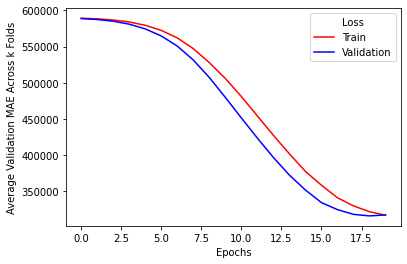

In [ ]:
import matplotlib.pyplot as plt
plt.plot(average_train_mae_history_dense, c="r")
plt.plot(average_val_mae_history_dense,c="b")
plt.legend(['Train','Validation'],title="Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Validation MAE Across k Folds")
plt.show()

# Final model configuration

* We decided to choose 20 epochs and 25 batch sizes
* we were able to increase eopochs with less computation time using pretrained model
* We were also able to decrease overfitting and Validation MAE using pretrained model

In [ ]:
pretrain_model = model_preTrain()

In [ ]:
pretrain_history = pretrain_model.fit(x=[front_features, kitchen_features, bathroom_features, bedroom_features, df], y=labels, epochs=20, batch_size=25)

Epoch 1/20
22/22 [==============================] - 0s 20ms/step - loss: 220952.8750 - mae: 220952.8750
Epoch 2/20
22/22 [==============================] - 0s 19ms/step - loss: 226438.2500 - mae: 226438.2500
Epoch 3/20
22/22 [==============================] - 0s 19ms/step - loss: 218555.8750 - mae: 218555.8750
Epoch 4/20
22/22 [==============================] - 0s 20ms/step - loss: 218556.6094 - mae: 218556.6094
Epoch 5/20
22/22 [==============================] - 0s 19ms/step - loss: 218330.2031 - mae: 218330.2031
Epoch 6/20
22/22 [==============================] - 0s 19ms/step - loss: 218468.8281 - mae: 218468.8281
Epoch 7/20
22/22 [==============================] - 0s 20ms/step - loss: 215624.5000 - mae: 215624.5000
Epoch 8/20
22/22 [==============================] - 0s 19ms/step - loss: 211521.9375 - mae: 211521.9375
Epoch 9/20
22/22 [==============================] - 0s 20ms/step - loss: 214720.5312 - mae: 214720.5312
Epoch 10/20
22/22 [==============================] - 0s 19ms/ste